In [1]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().resolve().parent))
from BeamPropagator import BeamPropagator
import HelperFuns as hf
import plotting
sys.path.remove(str(Path.cwd().resolve().parent))

import numpy as np
import matplotlib.pyplot as plt

In [2]:
wv = 2
h_len = 160
# x sampling array.
x_arr = np.linspace(-150, 150, 4096)

def propagate_viz_region(E_input, n_perturb=None):
    # Storage containers.
    fields = []
    z_pos = []
    hol_fields = [] 
    # Free space propagation.
    prop = BeamPropagator(wavelen = wv)
    prop.set_x_array(x_length=200, x_array=x_arr)
    prop.set_z_array(z_length = 120, num_samples = 200)
    prop.set_abs_bcs(80)
    prop.set_init_Efield(E_input)
    prop.propagate()
    # Add to storage.
    fields.extend(prop.field_steps)
    z_pos.extend(prop.z_arr)
    # Hologram propagation.
    hol_prop = BeamPropagator(wavelen = wv, index = 1.5)
    hol_prop.set_x_array(x_length = 200, x_array=x_arr)
    hol_prop.set_z_array(z_length = h_len, num_samples = 200, z_offset = z_pos[-1])
    hol_prop.set_abs_bcs(80)
    hol_prop.set_init_Efield(fields[-1])
    if n_perturb is not None:
        hol_prop.set_z_dep_idx(n_perturb)
    hol_prop.propagate()
    # Add to storage.
    fields.extend(hol_prop.field_steps)
    hol_fields.extend(hol_prop.field_steps)
    z_pos.extend(hol_prop.z_arr)
    # Free space propagation.
    prop.set_init_Efield(fields[-1])
    prop.set_z_array(z_length = 100, num_samples = 200, z_offset = z_pos[-1])
    prop.propagate()
    # Add to storage.
    fields.extend(prop.field_steps)
    z_pos.extend(prop.z_arr)
    # Return results.
    return hol_fields, fields, z_pos


# Set up the inital fields.
img_beam = hf.gaussian_amp(A = 1, x = x_arr, waist = 50, mu = -75) * hf.plane_wave_phase_factor(x_arr, wavelen=wv, theta = 24)
ref_beam = hf.gaussian_amp(A = 1, x = x_arr, waist = 50, mu = 75) * hf.plane_wave_phase_factor(x_arr, wavelen=wv, theta = -24)
# Propagate the beams separately.
hol_fields_img, fields_img, z_pos = propagate_viz_region(img_beam)
hol_fields_ref, fields_ref, z_pos = propagate_viz_region(ref_beam)
# Update the hologram region.
delta_idx = None
int_coeff = 100 * 0.01 * 4.5677e-3

hol_fields = np.array(hol_fields_img) + np.array(hol_fields_ref)
intensity = np.abs(hol_fields)**2 - np.abs(np.array(hol_fields_img))**2 - np.abs(np.array(hol_fields_ref))**2

delta_idx = hf.delta_idx_intensity(intensity, int_coeff)

hol_fields_img, fields_img, z_pos = propagate_viz_region(img_beam, n_perturb=delta_idx)
hol_fields_ref, fields_ref, z_pos = propagate_viz_region(ref_beam, n_perturb=delta_idx)

# Combine the fields and plot.
fields = np.array(fields_ref) #+ np.array(fields_img)

In [3]:
r_map = plotting.gen_rgb_cmap(color='red')
#r_map = plotting.gen_camp_from_color((255, 0, 0))

In [4]:
y_map = plotting.gen_camp_from_color((255, 247, 0), start_color=(0,0,0))

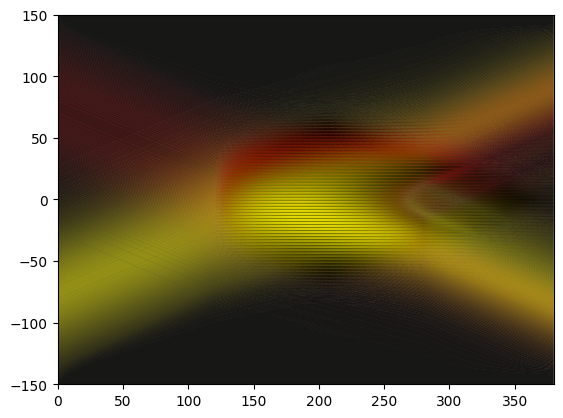

In [5]:
fig, ax = plotting.plot_contours(
    z_pos, 
    x_arr, 
    np.transpose(np.abs(fields_ref))**(1), 
    100, 
    cmap = r_map, 
    alpha_f = 0.7,
    alpha_c = 0.15,
    antialiased=True,
)
_, ax = plotting.plot_contours(
    z_pos, 
    x_arr, 
    np.transpose(np.abs(fields_img))**(1), 
    100, 
    cmap = y_map, 
    alpha_f = 0.7,
    alpha_c = 0.15,
    antialiased=True,
    ax=ax,
)
plt.show()

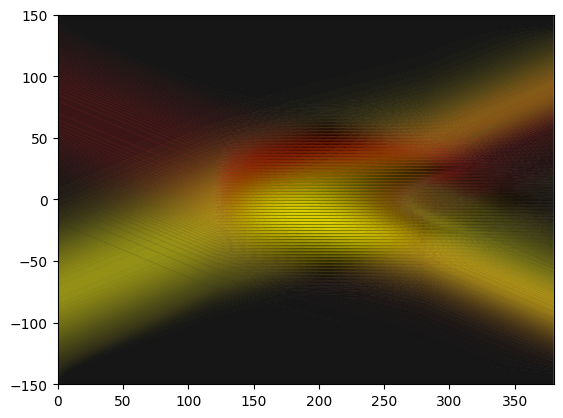

In [10]:
to_plot = [np.transpose(np.abs(fields_ref)), np.transpose(np.abs(fields_img))]
fig, ax = plotting.cplot_fields(
    z_pos,
    x_arr,
    to_plot,
    levels = 50,
    cmaps = [r_map, y_map],
    alphas=[0.7, 0.2],
)
plt.show()

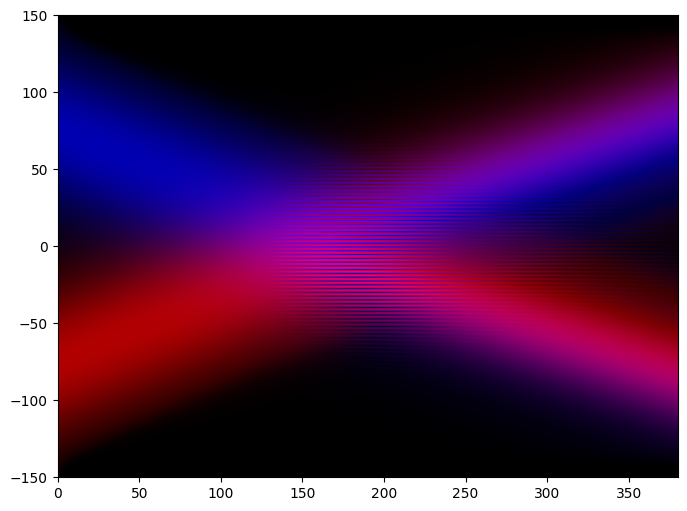

In [17]:
## Test bitmap generation.
bitmap = plotting.gen_rgb_bitmap(
    [np.transpose(np.abs(fields_ref)), np.transpose(np.abs(fields_img))], 
    channel_order=['r', 'b', 'g']
)
plt.figure(figsize=(8, 6))
plt.imshow(
    bitmap, 
    interpolation='nearest', 
    aspect='auto',
    extent=[z_pos[0], z_pos[-1], x_arr[0], x_arr[-1]],
)
plt.show()

In [8]:
plotting.save_bitmap_img(bitmap, 'test_img.bmp')